In [1]:
%matplotlib inline
import warnings
#warnings.filterwarnings("ignore")

import os,sys
import numpy as np
import pandas as pd
import astropy.stats as stat

import matplotlib
from   matplotlib import rc
rc('text', usetex=True)
import matplotlib.pyplot as plt
import time

rc('text', usetex=True)
font = {'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

sys.path.insert(1, '/home/amarins/ComponentSeparation/gmca/scripts')
import Extension4BINGO as cs
import statcosmo as statc

In [2]:
#####################################
#paths
#####################################
pathcls       = "/home/amarins/ComponentSeparation/gmca/outputs/ICAn4nr100" 
dir_hi        = "21cm"        #Directory name of the cls of the 21cm reconstruction maps
dir_fg        = "foregrounds" #Directory name of the cls of the foregrounds reconstruction maps
dir_prior     = "prior"       #Directory name of the cls of the prior maps, that can be (21cm + noise) masked
dir_noise     = "noise"       #Directory name of the cls of the noise maps, that can be (WhiteNoise or/and 1/f) masked
dir_pure      = "pure"        #Directory name of the cls of the (only) 21cm maps, masked or not.
dir_projnoise = "projnoise"   #Directory name of the cls of the noise maps, that can be (WhiteNoise or/and 1/f) masked
dir_projpure  = "projpure"    #Directory name of the cls of the (only) 21cm maps, masked or not.
dir_projprior = "projprior"   #

#Noise debias model
model     = "filipe"
#Bootstrap parameters
n_samples = 1e5

#Plot 
bin_ = 10
realisation = "L5"

In [3]:
Cls        = cs.loadcls(pathcls,dirs=[dir_hi,dir_fg,dir_prior,dir_noise,dir_pure])  
Cls_ndb    = statc.output_debias(Cls=Cls, model=model, output="Cls_debias",dir_hi = dir_hi, dir_prior=dir_prior, dir_noise = dir_noise)
Cls_binned = statc.data_binned(Cls_ndb) #building cls per bins, with different realisations

## Jacknnife

In [4]:
std_jack   = statc.jacknnife_stat(Cls_binned, stat_func=np.std)

/home/amarins/env/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


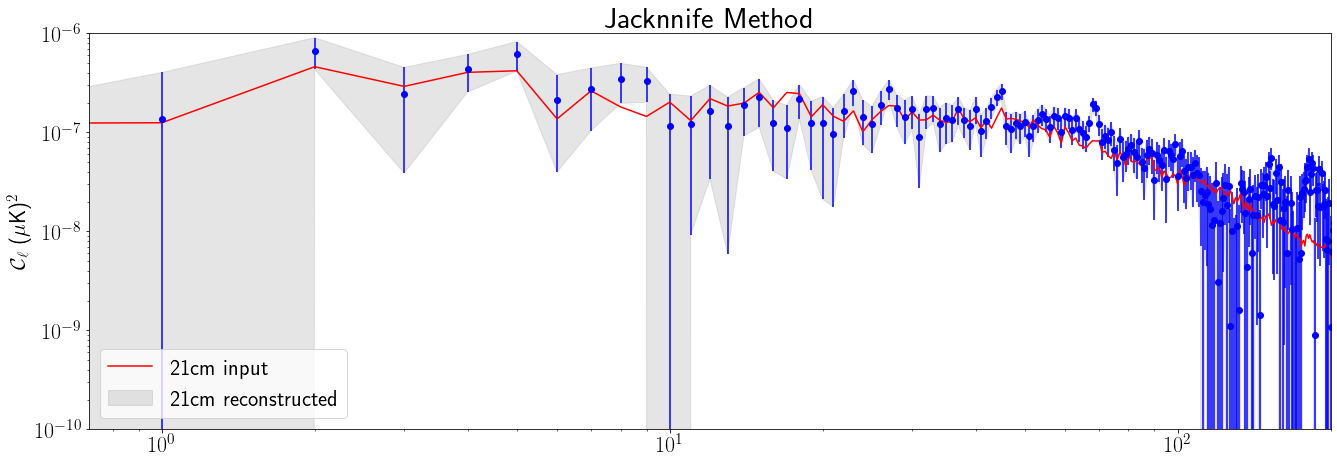

In [5]:
fig = plt.figure()
grid = plt.GridSpec(1,1,top=1.5,right=3)

l = np.arange(Cls_binned[0][0].size)
fact = 1#l*(l+1)/(2*np.pi)

ax = plt.subplot(grid[0,0])
plt.title("Jacknnife Method", fontsize=30)
plt.plot(    l, fact*Cls['pure'][realisation][bin_,:], color="red")
plt.errorbar(l, fact*Cls_ndb[realisation][bin_,:], yerr=std_jack[str(bin_)], fmt='o', color="blue")
plt.fill_between(l, fact*Cls_ndb[realisation][bin_,:] - std_jack[str(bin_)], fact*Cls_ndb[realisation][bin_,:] +std_jack[str(bin_)],
                 color='gray', alpha=0.2)
plt.xscale("log")
plt.yscale("log")
#plt.xlabel(r"$\ell$")
plt.ylabel(r"$\mathcal{C}_{\ell}$ ($\mu$K)$^2$")
plt.ylim(1e-10,1e-6)
plt.xlim(0,200)
plt.legend(["21cm input","21cm reconstructed"]);

## Bootstrap

In [ ]:
std_boot   = statc.bootstrap_stat(Cls_binned, n_samples=n_samples, stat_func=np.std)

In [ ]:
fig = plt.figure()
grid = plt.GridSpec(1,1,top=1.5,right=3)

l = np.arange(Cls_binned[0][0].size)
fact = 1#l*(l+1)/(2*np.pi)

ax = plt.subplot(grid[0,0])
plt.title("Bootstrap Method", fontsize=30)
plt.plot(    l, fact*Cls['pure'][realisation][bin_,:], color="red")
plt.errorbar(l, fact*Cls_ndb[realisation][bin_,:], yerr=std_boot[str(bin_)], fmt='o', color="blue")
plt.fill_between(l, fact*Cls_ndb[realisation][bin_,:] - std_boot[str(bin_)], fact*Cls_ndb[realisation][bin_,:] +std_boot[str(bin_)],
                 color='gray', alpha=0.2)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\mathcal{C}_{\ell}$ ($\mu$K)$^2$")

plt.legend(["21cm input","21cm reconstructed"])
plt.ylim(1e-9,1e-6)

plt.savefig("plot1.png");

# Theory

## (1) Jackknife variance estimator

$\hat{\theta}^{(-i)}_{(\mathcal{l}_{1})} = estimator\{\mathcal{C}^{L0}_{\mathcal{l}_{1}},\mathcal{C}^{L1}_{\mathcal{l}_{1}},\cdots,\mathcal{C}^{Li-1}_{\mathcal{l}_{1}},\mathcal{C}^{Li+1}_{\mathcal{l}_{1}},\cdots,\mathcal{C}^{LN-1}_{\mathcal{l}_{1}}\}$

$\vdots$

$\hat{\theta}^{(-i)}_{(\mathcal{l}_{max})} = estimator\{\mathcal{C}^{L0}_{\mathcal{l}_{max}},\mathcal{C}^{L1}_{\mathcal{l}_{max}},\cdots,\mathcal{C}^{Li-1}_{\mathcal{l}_{max}},\mathcal{C}^{Li+1}_{\mathcal{l}_{max}},\cdots,\mathcal{C}^{LN-1}_{\mathcal{l}_{max}}\}$

$\hat{\theta}^{(-i)} = [\hat{\theta}^{(-i)}_{(l_{1})},\hat{\theta}^{(-i)}_{(l_{2})},\cdots, \hat{\theta}^{(-i)}_{(l_{max})}]^{T}$


$[\hat{\theta}^{(-i)}] = \mathcal{l}_{max} \times 1$


$\langle \theta \rangle := \langle \hat{\theta}^{(-i)} \rangle _{i} = \displaystyle\frac{1}{N} \sum_{j=0}^{N-1} \hat{\theta}^{(-j)}$

$\displaystyle \mathrm{Jcov} = \frac{N-1}{N} \sum_{j=0}^{N-1}\left(\hat{\theta}^{(-j)} - \langle \theta \rangle\right)\left(\hat{\theta}^{(-j)} - \langle \theta \rangle\right)^T$

$[\mathrm{Jcov}] = \mathcal{l}_{max} \times \mathcal{l}_{max}$


$\mathrm{Jcov}$ é uma medida da variancia do $\langle \theta\rangle$, estimativa baseado em todos os dados

## (2) Bootstrap variance estimator

Seja $\mathbb{X}_n = [X_1, \cdots, X_n]$ amostra aleatória de tamanho n, obtida a partir de um cdf $G$ (desconhecida).

A estimativa de algum parâmetro desejável $\theta$ a partir de G é: 

$\displaystyle \hat{\theta} = \hat{\theta}(\mathbb{X}_n)$

Podemos obter estimativas do bias e da variância da estiamtiva do parâmetro numéricamente usando o $\mathrm{bootstrap\ method}$.

Algoritmo:

- Estimar $G$, a partir de um $\hat{G}$ empírico. (obtido a partir $\mathbb{X}_n$, assumindo cada valor igualmente provável: $1/N$)

- $\mathbf{bootstrap\ sample}$: Obtenha amostras aleatórias a partir de $\hat{G}$ (Cada sample deverá ser obtido a partir de $\mathbb{X}_n$)

- Estimar bias e variancia a partir dos bootstrap samples

$G \Longrightarrow \mathbb{X}_n \Longrightarrow \hat{G} \Longrightarrow \{\mathbb{X}_n^{*\ (k)},\ k\in\mathcal{I}_N\} \Longrightarrow \{\hat{\theta}^{*\ (k)}\} \Longrightarrow \hat{\theta}^{*} \Longrightarrow \mathrm{b}_{\hat{G}}, \mathrm{Var}_{\hat{G}}$

Na prática, a partir de $\mathbb{X}_n$, obtemos os $\mathbb{X}_n^{*\ (k)}$, cada um deles de tamanho 

$0 < [\mathbb{X}_n^{*\ (k)}] \le [\mathbb{X}_n]$

e construídos obtendo cada elemento aleatóriamente do conjunto amostral inicial (podendo haver exclusão e repetição de valores).

Com esses, podemos calcular:


$\displaystyle \langle \hat{\theta}^{*} \rangle := \frac{1}{N}\sum_{k=1}^{N}\hat{\theta}^{*\ (k)}$

$\mathrm{b}_{\hat{G}}\approx \langle \hat{\theta}^{*} \rangle - \hat{\theta}$

$\displaystyle \mathrm{Var}_{\hat{G}}\approx \frac{1}{N-1}\sum_{k=1}^{N}(\hat{\theta}^{*\ (k)} - \langle \hat{\theta}^{*} \rangle)^2$


De modo geral, Bootstrap se baseia no seguinte fato, segundo o método de Monte Carlo:

Seja $r(\hat{\theta},\theta)$ alguma quantidade a ser avaliada que relaciona o parâmetro em questão e o seu estimador (pex., bias, variância, ou cov). 

O estimador de $r(\hat{\theta},\theta)$ é:

$\displaystyle \mathbb{E}_{G}[r(\hat{\theta},\theta)] = \int \cdots \int \left( \prod_{k=1}^{n} dG(x_k)\right)r(\hat{\theta},\theta)$

Como $G$ é desconhecido, o bootstrap method estima a expressão acima através da cdf empírica $\hat{G}$.

$\displaystyle \mathbb{E}_{\hat{G}}[r(\hat{\theta}^*,\hat{\theta})] = \int \cdots \int \left( \prod_{k=1}^{n} d\hat{G}(x^*_k)\right)r(\hat{\theta}^*,\hat{\theta})$

Que podemos aproximar por:


$\displaystyle \mathbb{E}_{\hat{G}}[r(\hat{\theta}^*,\hat{\theta})] \approx \frac{1}{N}\sum^N_{k=1}r(\hat{\theta}^{*\ (k)},\hat{\theta})$